<a href="https://colab.research.google.com/github/rhiats/diab_sev_mimicIII/blob/main/Analysis_of_Patients_with_Type_2_Diabetes_in_ICU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Stratification Analysis of Patients with Type 2 Diabetes in ICU**

Person diagnosed with Diabetes.

Type 2 Diabetic ICD9 Codes (250)/ Admissions - 'diabet...'.

- Admissions- breakdown of insurance type. (one hot encode)
- Admissions - gender (one hot encode)
- Prescriptions  - Top 5 drugs (one hot encode)
- Prescriptions - Distribution number of drugs per patient

http://www.icd9data.com/2014/Volume1/240-279/249-259/250/250.00.htm

https://physionet.org/content/mimic3-carevue/1.4/

https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

In [1]:
!pip install kmodes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt


In [2]:
df_admissions=pd.read_csv('/content/drive/MyDrive/mimic-iii-clinical-database-carevue-subset-1.4/ADMISSIONS.csv.gz', compression='gzip')
df_patients=pd.read_csv('/content/drive/MyDrive/mimic-iii-clinical-database-carevue-subset-1.4/PATIENTS.csv.gz', compression='gzip')
df_presciptions=pd.read_csv('/content/drive/MyDrive/mimic-iii-clinical-database-carevue-subset-1.4/PRESCRIPTIONS.csv.gz', compression='gzip')

<ipython-input-2-8f50def5d0b2>:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_presciptions=pd.read_csv('/content/drive/MyDrive/mimic-iii-clinical-database-carevue-subset-1.4/PRESCRIPTIONS.csv.gz', compression='gzip')


**Identify Diabetic Patients**

In [3]:
def diabetetesFind(x):
  """
    Find patients diagnosed with Diabetes.
    @p: pandas series 'diagnosis'
    @r: dataframe with diabetic patients
  """
  x=str(x)
  x=x.lower()
  return x

df_admissions['diagnosis_lower']=df_admissions['diagnosis'].apply(diabetetesFind)
df_diab=df_admissions[df_admissions['diagnosis_lower'].str.contains(pat = 'diabet')]

num_patients=df_diab['subject_id'].nunique()
'There are {} patients in the ICU diagnosed diabetes.'.format(num_patients)

'There are 131 patients in the ICU diagnosed diabetes.'

**Distribution of Patients Gender**

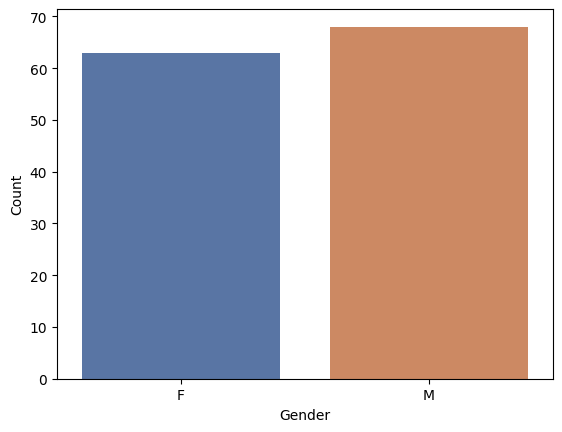

In [4]:
sub_id_diab=list(set(df_diab['subject_id'].to_list()))

df_gender=df_patients[df_patients['subject_id'].isin(sub_id_diab)][['subject_id','gender']]

fem_mal_df=df_gender.groupby(['gender']).count().reset_index()

fem_mal_df.rename(columns={"subject_id": "Count","gender": "Gender"}, inplace=True)

sns.barplot(data=fem_mal_df, x='Gender', y="Count", palette="deep")

plt.savefig("/content/drive/MyDrive/output/gender.png")

**Distribution of Insurance Types for Diabetic Patients**

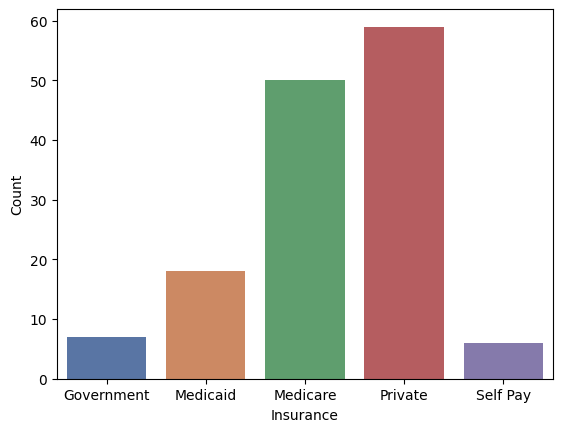

In [5]:
df_insur_diab=df_admissions[df_admissions['subject_id'].isin(sub_id_diab)][['subject_id','insurance']]
df_insur_diab.drop_duplicates(subset=['subject_id','insurance'],inplace=True)

insur_df_cnt=df_insur_diab.groupby(['insurance']).nunique().reset_index()

insur_df_cnt.rename(columns={"subject_id": "Count","insurance": "Insurance"}, inplace=True)

sns.barplot(data=insur_df_cnt, x='Insurance', y="Count", palette="deep")

plt.savefig("/content/drive/MyDrive/output/insurance.png")

**Top 3 Drugs used by Diabetic Patients in the ICU**

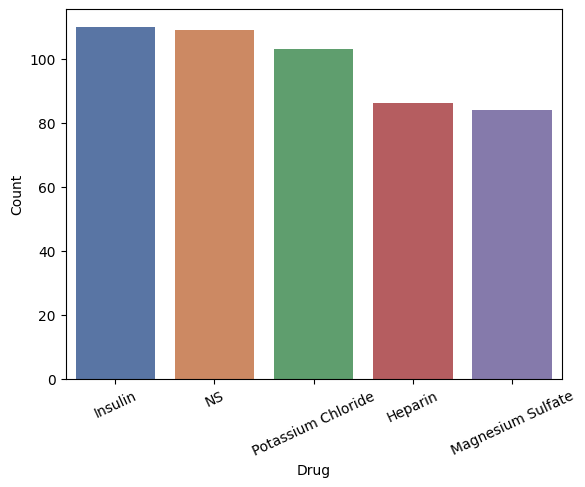

In [6]:
df_drug_diab=df_presciptions[df_presciptions['subject_id'].isin(sub_id_diab)][['subject_id','drug']]
df_drug=df_drug_diab.groupby(['drug']).nunique().reset_index()
df_drug.rename(columns={"subject_id": "Count","drug": "Drug"}, inplace=True)
df_top_5_drugs=df_drug.nlargest(5, 'Count')

sns.barplot(data=df_top_5_drugs, x='Drug', y="Count", palette="deep")
plt.xticks(rotation = 25)

plt.savefig("/content/drive/MyDrive/output/top5Drugs.png")

**Distribution of Medications per Person**

    subject_id  Number of Medications
78       19213                    182
15        3868                    150
89       21431                    147
81       20356                    131
68       17423                    130


<ipython-input-7-100319b91ee0>:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_drug_per_patient, x="Number of Medications",palette="Deep")


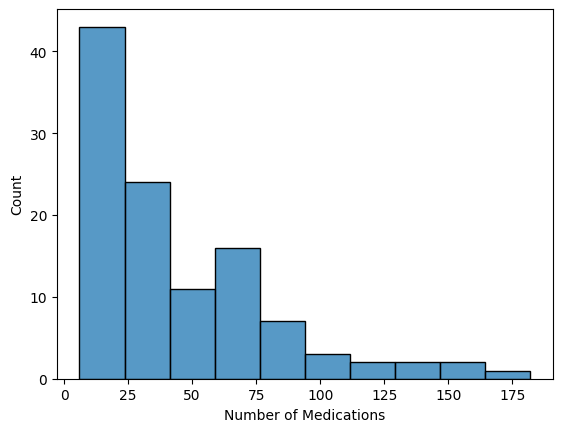

In [7]:
df_drug_per_patient=df_drug_diab.groupby(['subject_id']).nunique().reset_index()
df_drug_per_patient.rename(columns={"drug": "Number of Medications"}, inplace=True)
print(df_drug_per_patient.nlargest(5, 'Number of Medications'))

sns.histplot(data=df_drug_per_patient, x="Number of Medications",palette="Deep")

plt.savefig("/content/drive/MyDrive/output/drugs_per_patient.png")

In [8]:
drugs_19213_ser=df_presciptions[df_presciptions['subject_id']==19213]['drug']
drugs_19213_ser_lst=list(set(drugs_19213_ser.to_list()))
"Patient 19213 is on {} unique medications while in the ICU".format(len(drugs_19213_ser_lst))

'Patient 19213 is on 182 unique medications while in the ICU'

**Feature Matrix for PCA**

The most used insurance types is considered for those who switch insurance. In situations where people switch insurance once and both are equally used, then each instance is separately registered in the analysis. In this analysis patients switch insurance once, so both instances are used in the analysis. There are patients that do not have any prescriptions in the system.

The features considered are:
- Number of Medications a patient is using during treatment
- Gender (Female/Male)
- Insurance (Government, Medicaid, Medicare, Private, Self-Pay)
- Medication (Others, Heparin, Insulin, Magnesium Sulfate, Normal Saline (NS), Potassium Chloride)

In [9]:
from re import X
gend_insur_diab=df_gender.merge(df_insur_diab, on='subject_id',how='outer')

switch_insurance_df=gend_insur_diab[gend_insur_diab.duplicated(subset=['subject_id','gender'],keep=False)]

freq_switch_insurance_df=switch_insurance_df.groupby(["insurance","subject_id"]).count().reset_index()
switch_insurance_df.rename({"gender": "Frequency"}, inplace=True)

max_switch_insurance_df=freq_switch_insurance_df.groupby(["insurance","subject_id"]).max().reset_index()

gend_insur_drug_diab=gend_insur_diab.merge(df_drug_diab, on='subject_id',how='outer')

gend_insur_drug_diab['drug']=gend_insur_drug_diab['drug'].apply(diabetetesFind)

gend_insur_drug_diab.drop_duplicates(subset=['subject_id','gender','insurance','drug'],inplace=True)

#gend_insur_drug_diab.loc[~gend_insur_drug_diab.drug.isin(['insulin','ns','potassium chloride', 'heparin','magnesium sulfate']), 'drug'] = 'Other'

gend_insur_drug_diab['drug'].unique()

X_df=gend_insur_drug_diab.merge(df_drug_per_patient, on='subject_id',how='outer')

X_df.drop(columns=['subject_id'],axis=1, inplace=True)

X_df=X_df.fillna(0)

X=X_df.to_numpy()

#one_hot_encoded_data = pd.get_dummies(gend_insur_drug_diab_per_p_df, columns = ['gender', 'insurance','drug'])


<ipython-input-9-1f5422639954>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  switch_insurance_df.rename({"gender": "Frequency"}, inplace=True)


**Model Selection**

While I originally considered segmenting the patients using a PCA to calculate a severity score, I decided to use a Mixed Clustering model as the features are predominantly categorical. PCA would work best if the data was continuous so that the variation could be maximized. K-Prototype is used to handle the categorical and continuous data. A K-Means algorithm uses Euclidean distance which would not work will with the categorical data, but KModes finds the most frequent event instead of Euclidean distance. This mixed model handles both categorical and continuous data.

The Elbow method is used to select the optimal number of clusters. The aim is to minimize the distance of each point to the centroid. The optimal number of clusters is 5.

https://medium.com/analytics-vidhya/clustering-on-mixed-data-types-in-python-7c22b3898086

https://medium.com/@keswani-rohitkumar/k-prototypes-clustering-algorithm-f5d8e09a0104

https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

In [10]:
def elbow(df):
  """
    Calculate the optimal number of clusters.

  """
  cluster_num, cost=[],[]
  for i in range(2,11):
    cluster_num.append(i)
    kproto=KPrototypes(n_clusters=i)
    clusters=kproto.fit_predict(X,categorical=[0, 1,2])
    cost.append(kproto.cost_)


  return cluster_num,cost

cluster_n,cost_arr=elbow(X)

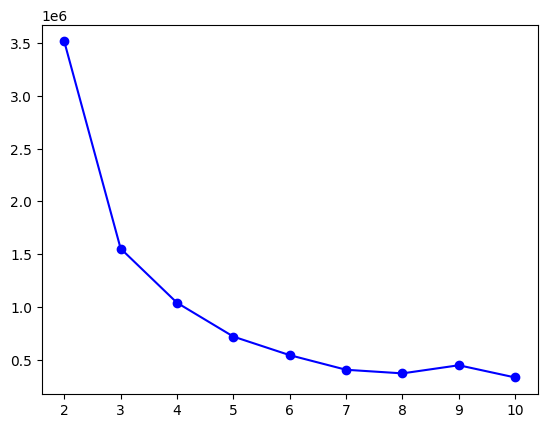

In [11]:
plt.plot(cluster_n, cost_arr, 'bo',linestyle='-')
plt.savefig('/content/drive/MyDrive/output/elbow.png')

**5 Clusters of Diabetic Patients**

In [12]:
kproto=KPrototypes(n_clusters=5)
clusters=kproto.fit_predict(X,categorical=[0, 1,2])
X_df["clusters"]=pd.Series(clusters,index=X_df.index)

**Describe Clusters**

Clusters 2, 4 and 5 are composed of predominantly female patients, while clusters 1 and 3 are predominantly males.

Clusters 1, 3, 4, and 5 are predominantly Medicare patients, so patients who are at least 65 years old. Cluster 2 is composed of patients on Private insurance with a median of 23 medications. Cluster 4 is only composed of Medicare and Medicaid insurance, so patients living on a lower income/fixed income. These patients are in a different income level than those of Medicare, who may be retired and living on a fixed income.

Patients is clusters 2, 3, and 5 are treating on Insulin and those is cluster 3 are also suffering from High Blood Pressure. Cluster 2 and 3 are the largest clusters in the analysis - both with ~1,400 patients.

In [13]:
X0_df=X_df[X_df['clusters']==0]
X1_df=X_df[X_df['clusters']==1]
X2_df=X_df[X_df['clusters']==2]
X3_df=X_df[X_df['clusters']==3]
X4_df=X_df[X_df['clusters']==4]

X0_df.head()

,gender,insurance,drug,Number of Medications,clusters
2897,M,Private,furosemide,128.0,0
2898,M,Private,lorazepam,128.0,0
2899,M,Private,morphine sulfate,128.0,0
2900,M,Private,trazodone hcl,128.0,0
2901,M,Private,olanzapine (disintegrating tablet),128.0,0


In [14]:
print("Cluster 1 Gender: \n\n",X0_df['gender'].value_counts(),"\n\n")
print("Cluster 2 Gender: \n\n",X1_df['gender'].value_counts(),"\n\n")
print("Cluster 3 Gender: \n\n",X2_df['gender'].value_counts(),"\n\n")
print("Cluster 4 Gender: \n\n",X3_df['gender'].value_counts(),"\n\n")
print("Cluster 5 Gender: \n\n",X4_df['gender'].value_counts(),"\n\n")

Cluster 1 Gender: 

 M    627
F    388
Name: gender, dtype: int64 


Cluster 2 Gender: 

 F    720
M    702
Name: gender, dtype: int64 


Cluster 3 Gender: 

 M    1126
F     309
Name: gender, dtype: int64 


Cluster 4 Gender: 

 F    478
M    145
Name: gender, dtype: int64 


Cluster 5 Gender: 

 F    770
M    535
Name: gender, dtype: int64 




In [15]:
print("Cluster 1 Insurance: \n\n",X0_df['insurance'].value_counts(),"\n\n")
print("Cluster 2 Insurance: \n\n",X1_df['insurance'].value_counts(),"\n\n")
print("Cluster 3 Insurance: \n\n",X2_df['insurance'].value_counts(),"\n\n")
print("Cluster 4 Insurance: \n\n",X3_df['insurance'].value_counts(),"\n\n")
print("Cluster 5 Insurance: \n\n",X4_df['insurance'].value_counts(),"\n\n")

Cluster 1 Insurance: 

 Medicare    495
Private     258
Self Pay    131
Medicaid    131
Name: insurance, dtype: int64 


Cluster 2 Insurance: 

 Private       716
Medicare      348
Self Pay      134
Government    118
Medicaid      106
Name: insurance, dtype: int64 


Cluster 3 Insurance: 

 Medicare    648
Private     590
Medicaid    197
Name: insurance, dtype: int64 


Cluster 4 Insurance: 

 Medicare    473
Medicaid    150
Name: insurance, dtype: int64 


Cluster 5 Insurance: 

 Medicare      882
Medicaid      333
Government     48
Private        42
Name: insurance, dtype: int64 




In [16]:
print("Cluster 1 Med: \n\n",X0_df['drug'].value_counts(),"\n\n")
print("Cluster 2 Med: \n\n",X1_df['drug'].value_counts(),"\n\n")
print("Cluster 3 Med: \n\n",X2_df['drug'].value_counts(),"\n\n")
print("Cluster 4 Med: \n\n",X3_df['drug'].value_counts(),"\n\n")
print("Cluster 5 Med: \n\n",X4_df['drug'].value_counts(),"\n\n")

Cluster 1 Med: 

 furosemide                        8
docusate sodium                   8
pantoprazole                      8
pantoprazole sodium               8
iso-osmotic dextrose              8
                                 ..
cyclosporine modified (neoral)    1
aluminum hydroxide suspension     1
midodrine hcl                     1
hydroxyzine hcl                   1
bactrim                           1
Name: drug, Length: 304, dtype: int64 


Cluster 2 Med: 

 insulin                             66
ns                                  64
potassium chloride                  59
insulin human regular               45
neutra-phos                         45
                                    ..
alprazolam                           1
amino acids 4.25% w/ dextrose 5%     1
alteplase (catheter clearance)       1
loperamide hcl                       1
ceftazidime                          1
Name: drug, Length: 245, dtype: int64 


Cluster 3 Med: 

 metoprolol                     17
iso-o

In [24]:
print("Cluster 1 Num Med: \n\n",X0_df['Number of Medications'].describe(),"\n\n")
print("Cluster 2 Num Med: \n\n",X1_df['Number of Medications'].describe(),"\n\n")
print("Cluster 3 Num Med: \n\n",X2_df['Number of Medications'].describe(),"\n\n")
print("Cluster 4 Num Med: \n\n",X3_df['Number of Medications'].describe(),"\n\n")
print("Cluster 5 Num Med: \n\n",X4_df['Number of Medications'].describe(),"\n\n")

Cluster 1 Num Med: 

 count    1015.000000
mean      127.303448
std         5.884367
min       111.000000
25%       128.000000
50%       130.000000
75%       131.000000
max       131.000000
Name: Number of Medications, dtype: float64 


Cluster 2 Num Med: 

 count    1422.000000
mean       23.996484
std         8.755052
min         0.000000
25%        18.000000
50%        23.000000
75%        30.000000
max        38.000000
Name: Number of Medications, dtype: float64 


Cluster 3 Num Med: 

 count    1435.000000
mean       86.234146
std        10.054431
min        71.000000
25%        73.500000
50%        89.000000
75%        91.000000
max       100.000000
Name: Number of Medications, dtype: float64 


Cluster 4 Num Med: 

 count    623.000000
mean     158.444623
std       14.957057
min      147.000000
25%      150.000000
50%      150.000000
75%      182.000000
max      182.000000
Name: Number of Medications, dtype: float64 


Cluster 5 Num Med: 

 count    1305.000000
mean       55.853

**Recommendations**

A pharma representative may want to market to health care professionals treating patients in cluster 2 because those are using insulin and are covered by private insurance. A doctor may want to intervene further on patients treating in cluster 3 beause those patients are at least 65 years old and suffering from both Diabetes and High Blood Pressure. These patients are already treating with insulin, but may need a change in dose or additional lifestyle intervention